In [44]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. Caricamento del Dataset
FILE_PATH = '../data/trajectories.csv'

# Leggiamo senza header perché il file contiene solo numeri
df = pd.read_csv(FILE_PATH, header=None, index_col=False)

print(f"Dimensione totale dataset: {df.shape}")

Dimensione totale dataset: (400400, 56)


## Pre-elaborazione: Suddivisione delle Traiettorie

In questa sezione viene definita e utilizzata la funzione `split_trajectories`. Poiché il dataset originale contiene diverse simulazioni concatenate sequenzialmente, è necessario separarle per poter addestrare correttamente i modelli (RNN e Transformer) su sequenze indipendenti.

La logica della funzione è la seguente:

1.  **Rilevamento dei reset temporali**: La funzione isola la prima colonna (il tempo). Utilizzando `np.diff`, individua gli indici in cui il valore del tempo decresce (il passaggio da un tempo finale $t_{end}$ a un tempo iniziale $t_0$), che segnala l'inizio di una nuova traiettoria.
2.  **Splitting**: Il DataFrame viene diviso in una lista di array `numpy` in corrispondenza di questi punti di taglio.
3.  **Feature Selection**: Da ogni traiettoria viene rimossa la colonna del tempo (indice 0), mantenendo solo le feature fisiche (dalla colonna 1 in poi) che serviranno come input per la rete neurale.

Infine, viene eseguito lo split e vengono stampate le statistiche di base (numero di traiettorie e dimensione) per verifica.

In [45]:
def split_trajectories(df):
    """
    Spezza il dataframe in una lista di array numpy, uno per ogni traiettoria.
    Assume che la colonna 0 sia il tempo.
    """
    trajectories = []

    # Identifichiamo dove il tempo ricomincia da capo (o è 0)
    # Se il tempo al passo t è minore del tempo al passo t-1, è una nuova traiettoria
    time_col = df.iloc[:, 0].values
    # Troviamo gli indici dove inizia una nuova traiettoria
    split_indices = np.where(np.diff(time_col) < 0)[0] + 1

    # Splittiamo il dataframe in questi punti
    traj_list = np.split(df.values, split_indices)

    # Rimuoviamo la colonna del tempo (col 0) dalle feature per il training
    # Teniamo solo le 55 colonne fisiche
    clean_trajectories = [t[:, 1:] for t in traj_list]

    return clean_trajectories

# Eseguiamo lo split
all_trajectories = split_trajectories(df)
print(f"Trovate {len(all_trajectories)} traiettorie distinte.")
print(f"Shape di una traiettoria: {all_trajectories[0].shape}")

Trovate 400 traiettorie distinte.
Shape di una traiettoria: (1001, 55)


In [46]:
# Dividiamo le traiettorie in Train (80%) e Test (20%)
train_traj, test_traj = train_test_split(all_trajectories, test_size=0.2, random_state=42)

# Normalizzazione (MinMax tra 0 e 1 o -1 e 1 è standard per dati quantistici)
# Fittiamo lo scaler SOLO sul training set per correttezza metodologica
scaler = MinMaxScaler(feature_range=(-1, 1))

# Concateniamo temporaneamente per fittare lo scaler
train_concat = np.vstack(train_traj)
scaler.fit(train_concat)

# Applichiamo la trasformazione a ogni singola traiettoria
train_traj_norm = [scaler.transform(t) for t in train_traj]
test_traj_norm = [scaler.transform(t) for t in test_traj]

## Generazione del Dataset (Sliding Windows)

Questa funzione trasforma la lista di traiettorie grezze in un dataset strutturato per l'apprendimento supervisionato, utilizzando la tecnica delle **finestre scorrevoli (sliding windows)**.

La funzione `create_dataset` opera come segue:

1.  **Iterazione per Traiettoria**: Itera su ogni singola simulazione (`trajectories`) separatamente. Questo passaggio è critico per evitare che la fine di una simulazione venga usata per predire l'inizio di quella successiva (data leakage).
2.  **Creazione Input ($X$)**: Estrae una finestra temporale di lunghezza `input_width`. Questa rappresenta il contesto storico che il modello osserverà.
3.  **Creazione Target ($y$)**: Estrae i passi temporali immediatamente successivi alla finestra di input, di lunghezza `forecast_horizon` (di default 1). Questo è ciò che il modello deve imparare a predire.

Il risultato sono due array numpy, $X$ e $y$, pronti per essere convertiti in Tensor per PyTorch.

In [ ]:
def create_dataset(trajectories, input_width, forecast_horizon=1):
    X, y = [], []
    for t in trajectories:
        for i in range(len(t) - input_width - forecast_horizon + 1):
            X.append(t[i : i + input_width])
            y.append(t[i + input_width : i + input_width + forecast_horizon])
    return np.array(X), np.array(y)

In [49]:
class QuantumRNN(Model):
    def __init__(self, hidden_units, output_dim, dropout_rate=0.2):
        super(QuantumRNN, self).__init__()

        # Layer di Normalizzazione
        self.norm = layers.LayerNormalization()

        # GRU 1: return_sequences=True per passare la sequenza alla seconda GRU
        # Aggiungiamo dropout e recurrent_dropout per regolarizzazione
        self.gru1 = layers.GRU(
            hidden_units,
            return_sequences=True,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        )

        # GRU 2: Elabora la sequenza e restituisce solo l'ultimo stato
        self.gru2 = layers.GRU(
            hidden_units,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        )

        # Dense Layer finale per la regressione (56 parametri)
        self.dense_out = layers.Dense(output_dim)

    def call(self, inputs, training=False):
        # Il parametro 'training' gestisce automaticamente il dropout:
        # viene attivato solo durante fit/train e disattivato durante l'esame (inferenza)
        x = self.norm(inputs)
        x = self.gru1(x, training=training)
        x = self.gru2(x, training=training)
        return self.dense_out(x)

## Architettura Transformer (Time Series)

Questo blocco implementa un modello **Transformer Encoder-only**, adattato per la previsione di serie temporali. A differenza delle RNN, che processano i dati sequenzialmente, il Transformer elabora l'intera finestra temporale in parallelo grazie al meccanismo di attenzione.

Il codice è suddiviso in due classi:

### 1. `TransformerBlock`
Rappresenta l'unità fondamentale (layer) dell'architettura. Ogni blocco applica le seguenti trasformazioni:
* **Multi-Head Self-Attention**: Permette al modello di mettere in relazione ogni passo temporale con tutti gli altri all'interno della finestra, catturando dipendenze a lungo raggio indipendentemente dalla distanza.
* **Feed Forward Network (FFN)**: Una rete densa a due strati che elabora le feature estratte dall'attenzione.
* **Add & Norm**: L'uso di connessioni residuali ($x + f(x)$) seguite da *Layer Normalization* è cruciale per stabilizzare i gradienti e permettere l'addestramento di reti profonde.

### 2. `QuantumTransformer` (Modello Completo)
È la classe che assembla i componenti:
1.  **Input Projection**: Un layer `Dense` proietta le 55 feature originali nello spazio latente di dimensione `embed_dim`.
2.  **Learnable Positional Encoding**: Poiché il meccanismo di attenzione è invariante all'ordine, viene sommato un vettore di pesi **addestrabili** (`pos_encoding`) all'input per fornire al modello informazioni sulla posizione temporale relativa.
3.  **Encoder Stack**: Una sequenza di `num_layers` blocchi Transformer ripetuti.
4.  **Global Average Pooling**: Invece di utilizzare solo l'ultimo step temporale (come spesso accade nelle RNN), qui viene calcolata la media delle feature su tutta la sequenza temporale ("Time Collapsing"). Questo rende la predizione più robusta al rumore dei singoli step.
5.  **Output Head**: Un ultimo layer denso proietta il risultato verso la dimensione di output (l'orizzonte di predizione).

In [51]:
# --- A. BLOCCO TRANSFORMER (Singolo strato ripetibile) ---
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # 1. Multi-Head Attention
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # 2. Feed Forward Network
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])

        # 3. Normalizzazione e Dropout
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        # Attention + Residual Connection + Norm
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed Forward + Residual Connection + Norm
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# --- B. MODELLO COMPLETO (Transformer per Time Series) ---
class QuantumTransformer(Model):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, output_dim, input_seq_len, dropout_rate=0.1):
        super(QuantumTransformer, self).__init__()

        # Proiezione dell'input (Feature 55 -> embed_dim)
        self.input_embedding = layers.Dense(embed_dim)

        # Positional Encoding (Imparabile)
        # Creiamo un vettore di pesi che rappresenta la posizione temporale
        self.pos_encoding = self.add_weight(
            name="pos_enc",
            shape=(1, input_seq_len, embed_dim),
            initializer="zeros",
            trainable=True
        )

        # Stack di Transformer Blocks
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim, rate=dropout_rate)
            for _ in range(num_layers)
        ]

        # Pooling e Output
        self.global_avg_pooling = layers.GlobalAveragePooling1D()
        self.dropout_final = layers.Dropout(dropout_rate)
        self.dense_out = layers.Dense(output_dim)

    def call(self, inputs, training=False):
        # 1. Embedding + Posizione
        x = self.input_embedding(inputs)
        x = x + self.pos_encoding # Somma element-wise

        # 2. Passaggio nei blocchi
        for block in self.transformer_blocks:
            x = block(x, training=training)

        # 3. Output Head
        x = self.global_avg_pooling(x)
        x = self.dropout_final(x, training=training)
        return self.dense_out(x)

In [52]:
def get_dataset_for_config(window_size, batch_size):
    """Genera il dataset in base alla finestra temporale della config"""
    # Creazione numpy
    X_tr, y_tr = create_dataset(train_traj_norm, input_width=window_size)
    X_te, y_te = create_dataset(test_traj_norm, input_width=window_size)

    # Squeeze target
    y_tr = y_tr.squeeze(1)
    y_te = y_te.squeeze(1)

    # Creazione tf.data
    train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))
    train_ds = train_ds.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    test_ds = tf.data.Dataset.from_tensor_slices((X_te, y_te)).batch(batch_size)
    return train_ds, test_ds, X_te, y_te

# Funzioni di Augmentation
def apply_masking(x, prob=0.15):
    mask = tf.random.uniform(shape=tf.shape(x)) > prob
    return x * tf.cast(mask, dtype=x.dtype)

def apply_noise(x, stddev=0.05):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=stddev, dtype=x.dtype)
    return x + noise

## Configurazione Sperimentale: Modelli Ricorrenti

In questa sezione vengono definiti tre scenari distinti (`HYPERPARAMETERS_LIST`) per testare come la complessità del modello e la lunghezza della memoria storica influenzano le prestazioni. La strategia segue un approccio incrementale:

| Configurazione | Window | Units | Dropout | LR ($\eta$) | Descrizione |
| :--- | :---: | :---: | :---: | :---: | :--- |
| **Config_A (Small)** | 10 | 32 | 0.1 | 0.01 | **Modello Leggero**: Bassa capacità, alto learning rate. Serve per verificare rapidamente se la rete apprende (sanity check). Rischio di *underfitting*. |
| **Config_B (Medium)** | 10 | 64 | 0.2 | 0.001 | **Baseline**: Configurazione bilanciata con capacità standard e dropout moderato. È il punto di riferimento. |
| **Config_C (Large)** | **20** | **128** | **0.3** | **0.0005** | **Modello Complesso**: Raddoppia la finestra temporale (memoria più lunga) e le unità. Richiede un dropout più alto per prevenire l'*overfitting* e un learning rate basso per una convergenza stabile. |

Questa griglia permette di valutare il trade-off tra capacità computazionale e generalizzazione.

In [55]:
HYPERPARAMETERS_LIST = [
    {
        "name": "Config_A (Small)",
        "window_size": 10,
        "units": 32,
        "dropout": 0.1,
        "learning_rate": 0.01,
        "batch_size": 64
    },
    {
        "name": "Config_B (Medium - Standard)",
        "window_size": 10,
        "units": 64,
        "dropout": 0.2,
        "learning_rate": 0.001,
        "batch_size": 64
    },
    {
        "name": "Config_C (Large - Long Memory)",
        "window_size": 20,
        "units": 128,
        "dropout": 0.3,
        "learning_rate": 0.0005,
        "batch_size": 128
    }
]


In [56]:
import os
import gc
from tqdm import tqdm

def run_experiment(config):
    print(f"\n--- Inizio Training RNN: {config['name']} ---")

    # 1. Preparazione Dati
    train_ds, test_ds, _, _ = get_dataset_for_config(config['window_size'], config['batch_size'])

    # 2. Creazione Modello
    model = QuantumRNN(hidden_units=config['units'], output_dim=55, dropout_rate=config['dropout'])

    # 3. Setup Training
    optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    loss_fn = tf.keras.losses.MeanSquaredError()

    train_loss_metric = tf.keras.metrics.Mean()
    test_loss_metric = tf.keras.metrics.Mean()
    train_mae_metric = tf.keras.metrics.MeanAbsoluteError()

    @tf.function
    def train_step(x, y, phase):
        if phase == "masking": x = apply_masking(x)
        elif phase == "noise": x = apply_noise(x)
        with tf.GradientTape() as tape:
            preds = model(x, training=True)
            loss = loss_fn(y, preds)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_loss_metric.update_state(loss)
        train_mae_metric.update_state(y, preds)
        return loss

    @tf.function
    def test_step(x, y):
        preds = model(x, training=False)
        loss = loss_fn(y, preds)
        test_loss_metric.update_state(loss)

    # 4. Loop Epoche
    history = {'loss': [], 'val_loss': [], 'mae': []}
    EPOCHS = 30

    for epoch in range(EPOCHS):
        if epoch < 10: phase, desc = "standard", "Standard"
        elif epoch < 20: phase, desc = "masking", "Masking"
        else: phase, desc = "noise", "Noise"

        train_loss_metric.reset_state()
        test_loss_metric.reset_state()
        train_mae_metric.reset_state()

        with tqdm(total=len(train_ds), desc=f"Ep {epoch+1}/{EPOCHS} [{config['name']}-{desc}]", unit="bt", leave=False) as pbar:
            for x_b, y_b in train_ds:
                l = train_step(x_b, y_b, phase)
                pbar.set_postfix({'loss': f'{l:.4f}'})
                pbar.update(1)

        for x_te, y_te in test_ds:
            test_step(x_te, y_te)

        history['loss'].append(train_loss_metric.result().numpy())
        history['val_loss'].append(test_loss_metric.result().numpy())
        history['mae'].append(train_mae_metric.result().numpy())

    # --- SALVATAGGIO STORIA CSV ---
    safe_name = config['name'].replace(" ", "_").replace("(", "").replace(")", "")
    pd.DataFrame(history).to_csv(f"../models/history/rnn_{safe_name}.csv", index=False)
    print(f"Storia salvata: ../models/history/rnn_{safe_name}.csv")

    return history, model

# --- ESECUZIONE MAIN LOOP RNN ---
os.makedirs('../models', exist_ok=True)
results_rnn = {}

for config in HYPERPARAMETERS_LIST:
    tf.keras.backend.clear_session()
    gc.collect()

    hist, trained_model = run_experiment(config)
    results_rnn[config['name']] = hist

    # Salvataggio Pesi
    safe_name = config['name'].replace(" ", "_").replace("(", "").replace(")", "")
    file_name = f"../models/weights/rnn_{safe_name}.weights.h5"
    trained_model.save_weights(file_name)
    print(f"PESI SALVATI: {file_name}")

print("\nEsecuzione RNN completata.")


--- Inizio Training RNN: Config_A (Small) ---


📜 Storia salvata: ../models/history/rnn_Config_A_Small.csv
✅ PESI SALVATI: ../models/weights/rnn_Config_A_Small.weights.h5

--- Inizio Training RNN: Config_B (Medium - Standard) ---


2026-01-20 20:58:19.203832: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


📜 Storia salvata: ../models/history/rnn_Config_B_Medium_-_Standard.csv
✅ PESI SALVATI: ../models/weights/rnn_Config_B_Medium_-_Standard.weights.h5

--- Inizio Training RNN: Config_C (Large - Long Memory) ---


📜 Storia salvata: ../models/history/rnn_Config_C_Large_-_Long_Memory.csv
✅ PESI SALVATI: ../models/weights/rnn_Config_C_Large_-_Long_Memory.weights.h5

Esecuzione RNN completata.


## Configurazione Sperimentale: Modelli Transformer

Parallelamente ai modelli ricorrenti, vengono testate tre architetture basate su **Attention** (`TRANSFORMER_CONFIGS`). Qui gli iperparametri controllano la profondità e la capacità di astrazione del meccanismo di attenzione.

I parametri chiave variati sono:
* **`num_heads`**: Il numero di "teste" di attenzione parallele. Più teste permettono al modello di focalizzarsi su diversi aspetti della relazione temporale contemporaneamente.
* **`num_layers`**: La profondità della rete (numero di blocchi Transformer impilati).
* **`embed_dim`**: La dimensione dello spazio latente in cui vengono proiettati i dati.

| Config | Heads | Layers | Embed Dim | Note |
| :--- | :---: | :---: | :---: | :--- |
| **Transf_A** | 2 | 1 | 32 | **Shallow**: Un solo strato, poche teste. Simile a una regressione avanzata con attenzione semplice. |
| **Transf_B** | 4 | 2 | 64 | **Intermediate**: Aumenta la capacità di rappresentazione (embedding 64) e la profondità. Bilanciamento tra velocità e performance. |
| **Transf_C** | 4 | 3 | 128 | **Deep & Wide**: Modello profondo (3 layer) con finestra temporale estesa ($T=20$). Ideale per catturare dipendenze complesse a lungo termine, ma richiede più dati e regolarizzazione. |

In [36]:
TRANSFORMER_CONFIGS = [
    {
        "name": "Transf_A (Small)",
        "window_size": 10,
        "embed_dim": 32,      # Dimensione interna (simile a units)
        "num_heads": 2,       # Quante "teste" guardano i dati
        "ff_dim": 32,         # Dimensione rete interna al blocco
        "num_layers": 1,      # Solo 1 blocco (leggero)
        "dropout": 0.1,
        "learning_rate": 0.001,
        "batch_size": 64
    },
    {
        "name": "Transf_B (Medium)",
        "window_size": 10,
        "embed_dim": 64,
        "num_heads": 4,       # Più attenzione ai dettagli
        "ff_dim": 64,
        "num_layers": 2,      # 2 Blocchi sovrapposti
        "dropout": 0.2,
        "learning_rate": 0.0005, # LR più basso per stabilità
        "batch_size": 64
    },
    {
        "name": "Transf_C (Large - Deep)",
        "window_size": 20,    # Finestra più lunga
        "embed_dim": 128,
        "num_heads": 4,
        "ff_dim": 128,
        "num_layers": 3,      # 3 Blocchi (Modello profondo)
        "dropout": 0.3,
        "learning_rate": 0.0001,
        "batch_size": 128
    }
]

In [60]:
def run_transformer_experiment(config):
    print(f"\n--- Inizio Training Transformer: {config['name']} ---")

    # 1. Preparazione Dati
    train_ds, test_ds, _, _ = get_dataset_for_config(config['window_size'], config['batch_size'])

    # 2. Creazione Modello
    model = QuantumTransformer(
        num_layers=config['num_layers'],
        embed_dim=config['embed_dim'],
        num_heads=config['num_heads'],
        ff_dim=config['ff_dim'],
        output_dim=55,
        input_seq_len=config['window_size'],
        dropout_rate=config['dropout']
    )

    dummy_x = tf.random.uniform((1, config['window_size'], 55))
    _ = model(dummy_x)

    # 3. Setup Training
    optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    loss_fn = tf.keras.losses.MeanSquaredError()

    train_loss_metric = tf.keras.metrics.Mean()
    test_loss_metric = tf.keras.metrics.Mean()
    train_mae_metric = tf.keras.metrics.MeanAbsoluteError()

    @tf.function
    def train_step(x, y, phase):
        if phase == "masking": x = apply_masking(x)
        elif phase == "noise": x = apply_noise(x)
        with tf.GradientTape() as tape:
            preds = model(x, training=True)
            loss = loss_fn(y, preds)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_loss_metric.update_state(loss)
        train_mae_metric.update_state(y, preds)
        return loss

    @tf.function
    def test_step(x, y):
        preds = model(x, training=False)
        loss = loss_fn(y, preds)
        test_loss_metric.update_state(loss)

    # 4. Loop Epoche
    history = {'loss': [], 'val_loss': [], 'mae': []}
    EPOCHS = 30

    for epoch in range(EPOCHS):
        if epoch < 10: phase, desc = "standard", "Standard"
        elif epoch < 20: phase, desc = "masking", "Masking"
        else: phase, desc = "noise", "Noise"

        train_loss_metric.reset_state()
        test_loss_metric.reset_state()
        train_mae_metric.reset_state()

        with tqdm(total=len(train_ds), desc=f"Ep {epoch+1}/{EPOCHS} [{config['name']}-{desc}]", unit="bt", leave=False) as pbar:
            for x_b, y_b in train_ds:
                l = train_step(x_b, y_b, phase)
                pbar.set_postfix({'loss': f'{l:.4f}'})
                pbar.update(1)

        for x_te, y_te in test_ds:
            test_step(x_te, y_te)

        history['loss'].append(train_loss_metric.result().numpy())
        history['val_loss'].append(test_loss_metric.result().numpy())
        history['mae'].append(train_mae_metric.result().numpy())

    # --- SALVATAGGIO STORIA CSV ---
    safe_name = config['name'].replace(" ", "_").replace("(", "").replace(")", "")
    pd.DataFrame(history).to_csv(f"../models/history/transf_{safe_name}.csv", index=False)
    print(f"Storia salvata: ../models/history/transf_{safe_name}.csv")

    return history, model

# --- ESECUZIONE MAIN LOOP TRANSFORMER ---
results_transf = {}

for config in TRANSFORMER_CONFIGS:
    tf.keras.backend.clear_session()
    gc.collect()

    hist, trained_model = run_transformer_experiment(config)
    results_transf[config['name']] = hist

    # Salvataggio Pesi
    safe_name = config['name'].replace(" ", "_").replace("(", "").replace(")", "")
    file_name = f"../models/weights/transf_{safe_name}.weights.h5"
    trained_model.save_weights(file_name)
    print(f"PESI SALVATI: {file_name}")

print("\nEsecuzione Transformer completata.")


--- Inizio Training Transformer: Transf_A (Small) ---


📜 Storia salvata: ../models/history_transf_Transf_A_Small.csv
✅ PESI SALVATI: ../models/transf_Transf_A_Small.weights.h5

--- Inizio Training Transformer: Transf_B (Medium) ---


📜 Storia salvata: ../models/history_transf_Transf_B_Medium.csv
✅ PESI SALVATI: ../models/transf_Transf_B_Medium.weights.h5

--- Inizio Training Transformer: Transf_C (Large - Deep) ---


2026-01-21 02:20:55.789299: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


📜 Storia salvata: ../models/history_transf_Transf_C_Large_-_Deep.csv
✅ PESI SALVATI: ../models/transf_Transf_C_Large_-_Deep.weights.h5

Esecuzione Transformer completata.


In [64]:
# GRAFICI
plt.style.use('seaborn-v0_8-whitegrid')

def plot_training_phases_detailed(history, config_name, filename):
    """
    Plotta Loss e MAE con linee verticali allineate perfettamente alle epoche 10 e 20.
    """
    epochs = range(1, len(history['loss']) + 1)

    # Creiamo una figura con 2 grafici affiancati
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # --- GRAFICO 1: LOSS (MSE) ---
    ax1.plot(epochs, history['loss'], label='Train Loss', color='#1f77b4', linewidth=2)
    ax1.plot(epochs, history['val_loss'], label='Validation Loss', color='#ff7f0e', linestyle='--', linewidth=2)

    # Calcolo posizione testo
    y_min, y_max = ax1.get_ylim()
    text_y_pos = y_max - (y_max - y_min) * 0.05

    # --- MODIFICA QUI: Linee verticali su interi esatti ---

    # Fase 1: Standard (Testo centrato su epoca 5)
    ax1.text(5, text_y_pos, 'FASE 1:\nSTANDARD', ha='center', va='top', fontsize=10, fontweight='bold', color='gray', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

    # Linea su Epoca 10 (Fine Standard / Inizio Masking)
    ax1.axvline(x=10, color='red', linestyle='--', alpha=0.5, linewidth=1.5)

    # Fase 2: Masking (Testo centrato su epoca 15)
    ax1.text(15, text_y_pos, 'FASE 2:\nMASKING', ha='center', va='top', fontsize=10, fontweight='bold', color='gray', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

    # Linea su Epoca 20 (Fine Masking / Inizio Noise)
    ax1.axvline(x=20, color='red', linestyle='--', alpha=0.5, linewidth=1.5)

    # Fase 3: Noise (Testo centrato su epoca 25)
    ax1.text(25, text_y_pos, 'FASE 3:\nNOISE', ha='center', va='top', fontsize=10, fontweight='bold', color='gray', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

    ax1.set_title(f'Training Dynamics - {config_name}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoche')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend(loc='lower left')
    ax1.grid(True, alpha=0.3)

    # Impostiamo i tick dell'asse X per mostrare i numeri chiave
    # Questo forza il grafico a mostrare 1, 10, 20, 30 sull'asse
    ax1.set_xticks([1, 5, 10, 15, 20, 25, 30])

    # --- GRAFICO 2: MAE ---
    ax2.plot(epochs, history['mae'], label='Train MAE', color='#2ca02c', linewidth=2)

    # Linee verticali anche qui (esattamente su 10 e 20)
    ax2.axvline(x=10, color='red', linestyle='--', alpha=0.5)
    ax2.axvline(x=20, color='red', linestyle='--', alpha=0.5)

    ax2.set_title('Mean Absolute Error Evolution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoche')
    ax2.set_ylabel('MAE')
    ax2.set_xticks([1, 5, 10, 15, 20, 25, 30]) # Forza i tick anche qui
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("../plots/training/" + filename, dpi=300)
    plt.show()

def plot_trajectory_check(model, trajectories_list, window_size, config_name, filename):
    """
    Confronto Predizione vs Realtà su una traiettoria di test.
    """
    # Prendiamo una traiettoria di test a caso (es. indice 0)
    traj_idx = 1
    if len(trajectories_list) > 0:
        real_traj = trajectories_list[traj_idx]

        # Creazione input sequenziale
        X_seq, y_seq = [], []
        for i in range(len(real_traj) - window_size):
            X_seq.append(real_traj[i : i + window_size])
            y_seq.append(real_traj[i + window_size])

        X_seq = np.array(X_seq)
        y_seq = np.array(y_seq)

        # Predizione
        print("Generazione predizioni per il grafico...")
        y_pred = model.predict(X_seq, batch_size=32, verbose=0)

        # Plot
        plt.figure(figsize=(14, 6))
        feature_idx = 0 # Magnetizzazione Z (Feature più importante)

        plt.plot(y_seq[:, feature_idx], label='Realtà (Ground Truth)', color='black', alpha=0.7, linewidth=2)
        plt.plot(y_pred[:, feature_idx], label=f'Predizione ({config_name})', color='#d62728', linestyle='--', linewidth=1.5)

        plt.title(f'Verifica Traiettoria: {config_name} (Window: {window_size})', fontsize=14, fontweight='bold')
        plt.xlabel('Time Steps')
        plt.ylabel('Valore Normalizzato')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig("../plots/predictions/" + filename, dpi=300)
        plt.show()
    else:
        print("Errore: Lista traiettorie vuota.")



📊 Generando grafici di addestramento per: Config_A (Small)


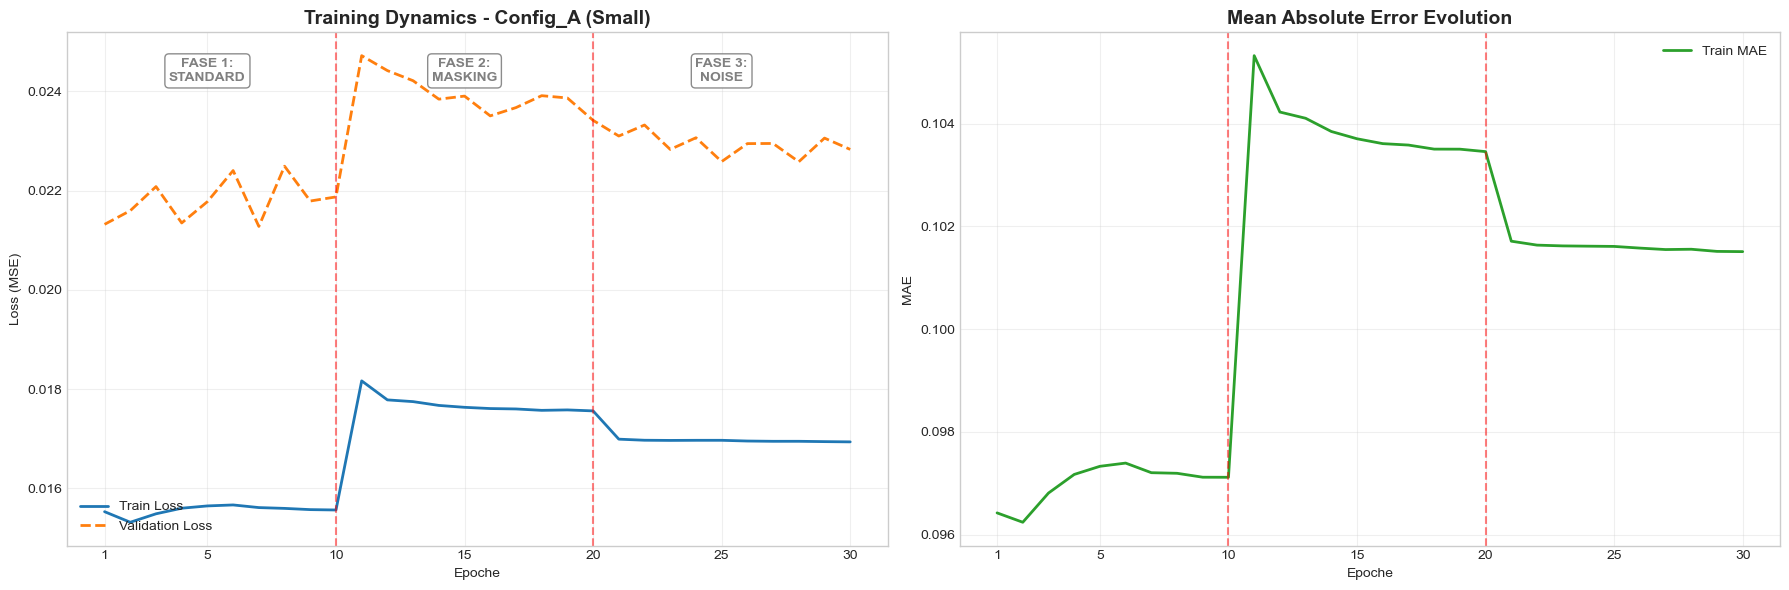

🔮 Generando grafici di predizione per: Config_A (Small)
Generazione predizioni per il grafico...


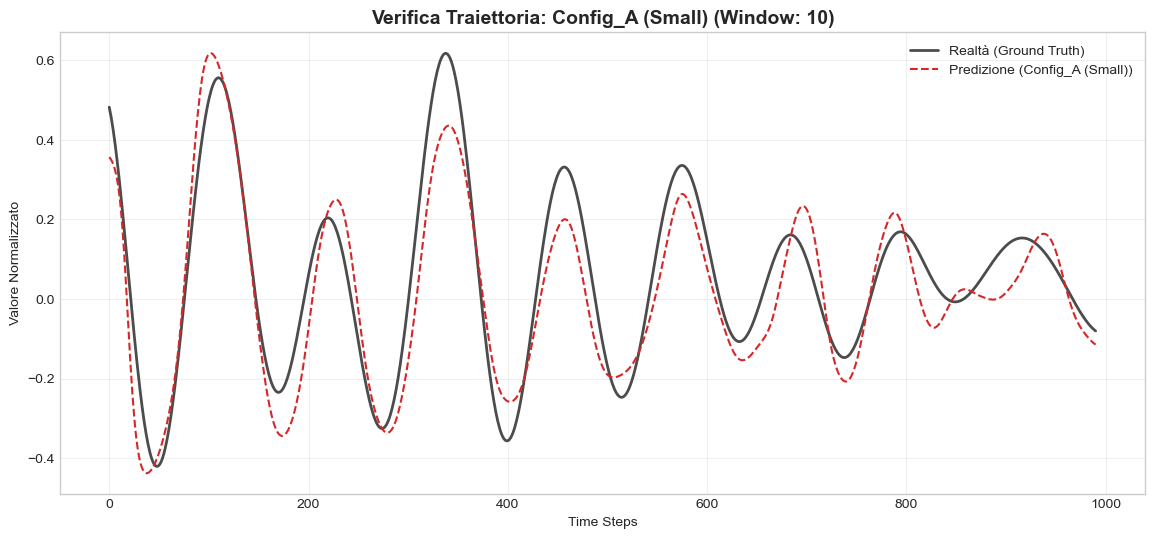


📊 Generando grafici di addestramento per: Config_B (Medium - Standard)


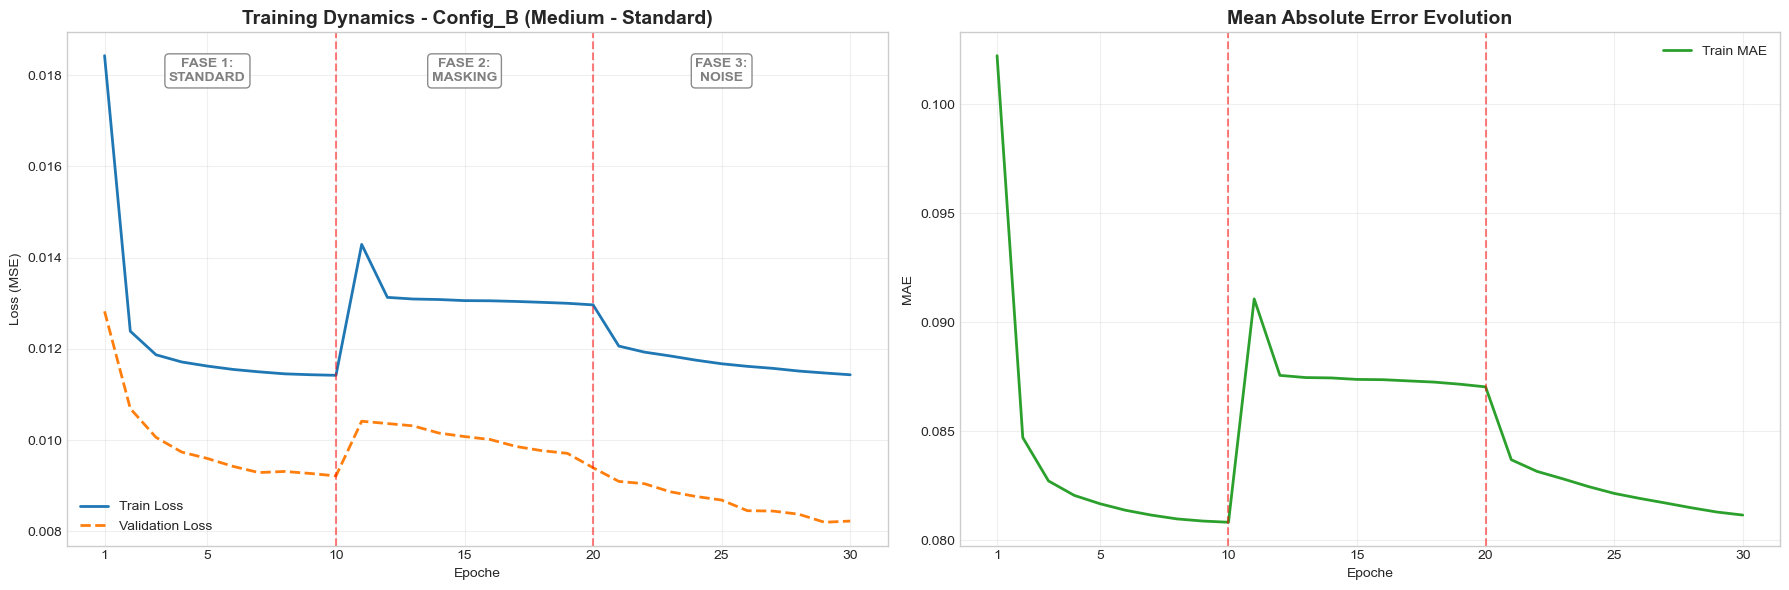

🔮 Generando grafici di predizione per: Config_B (Medium - Standard)
Generazione predizioni per il grafico...


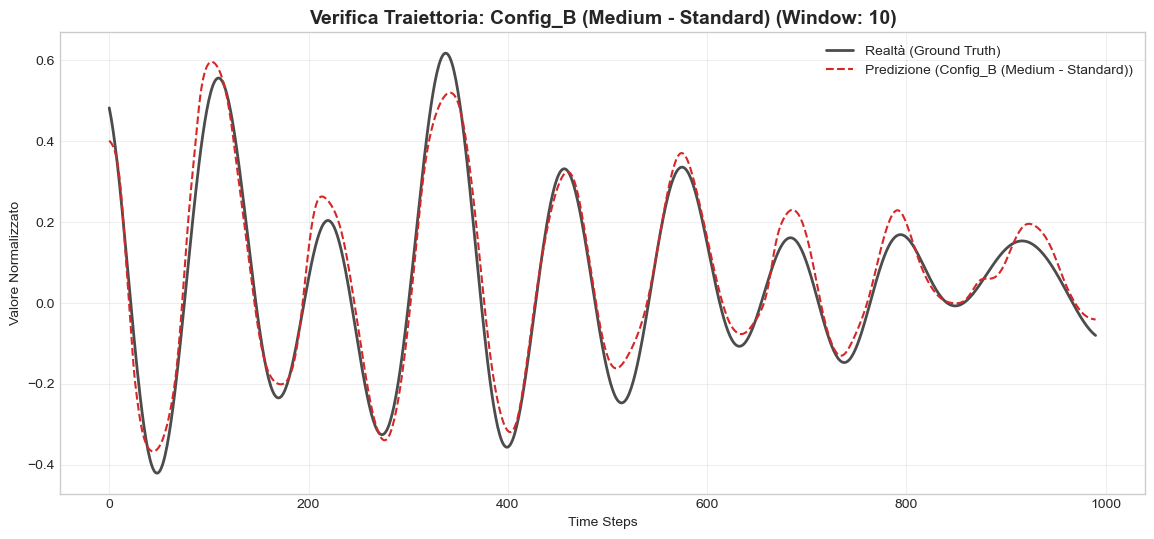


📊 Generando grafici di addestramento per: Config_C (Large - Long Memory)


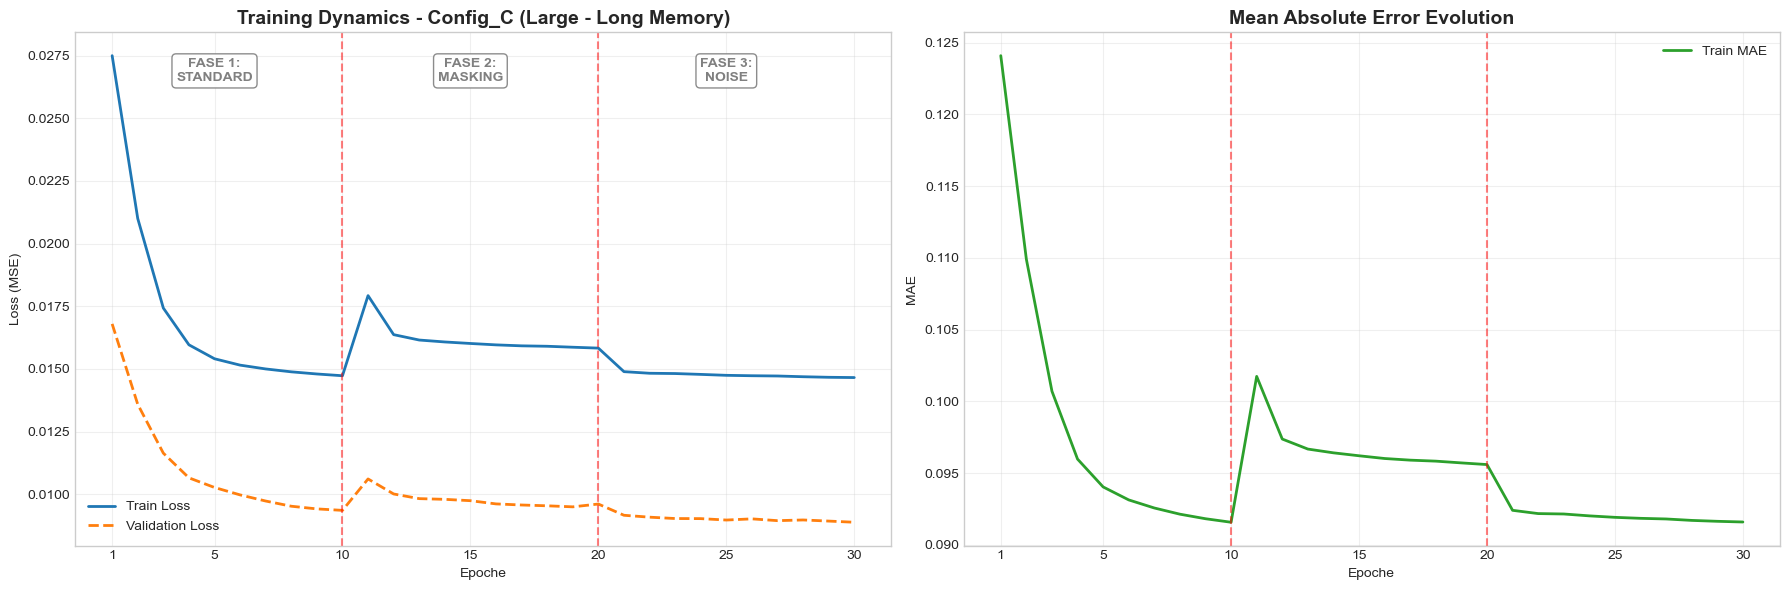

🔮 Generando grafici di predizione per: Config_C (Large - Long Memory)
Generazione predizioni per il grafico...


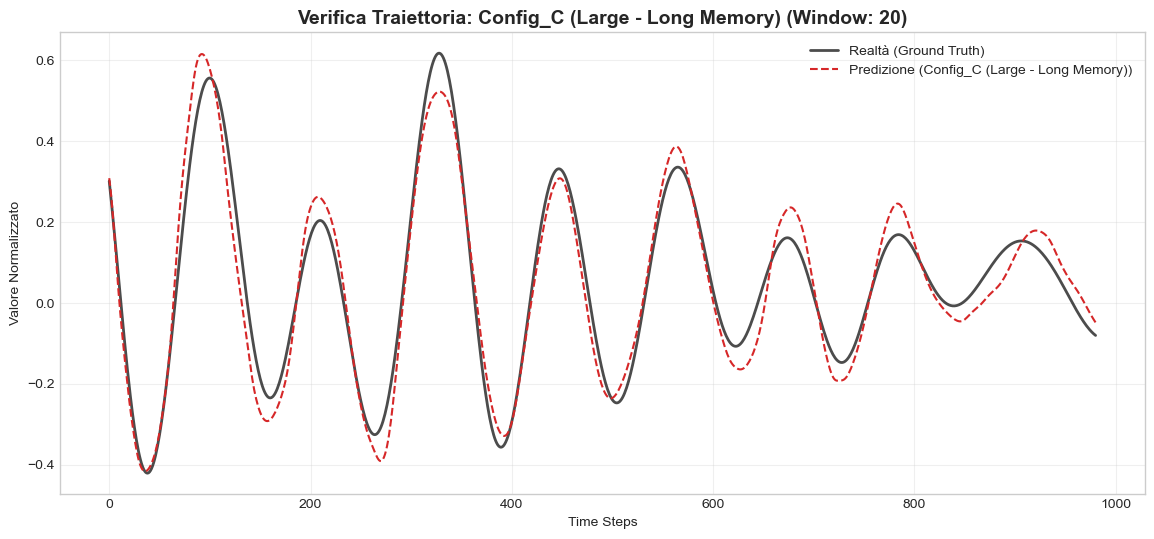


📊 Generando grafici di addestramento per: Transf_A (Small)


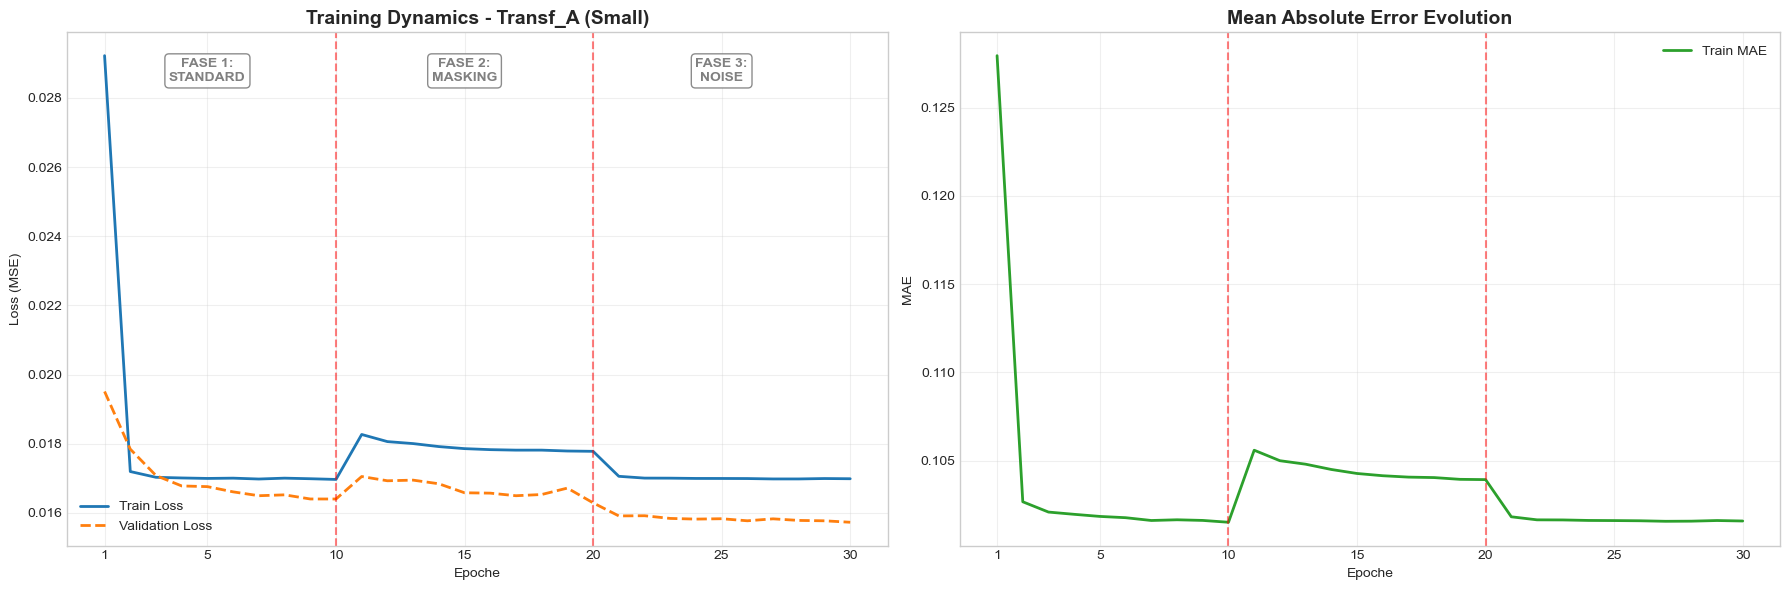

🔮 Generando grafici di predizione per: Transf_A (Small)
Generazione predizioni per il grafico...


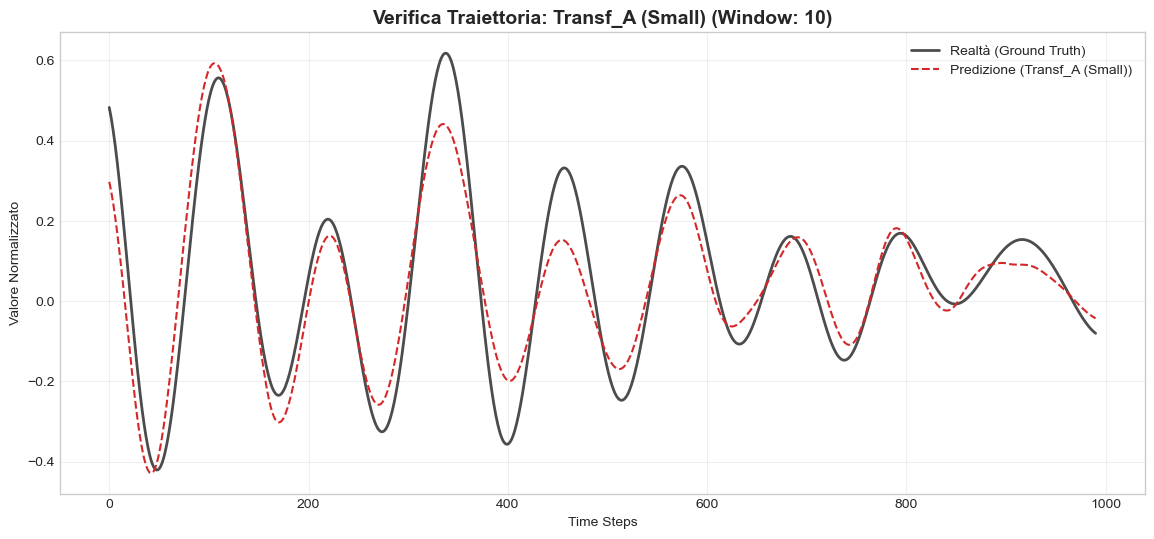


📊 Generando grafici di addestramento per: Transf_B (Medium)


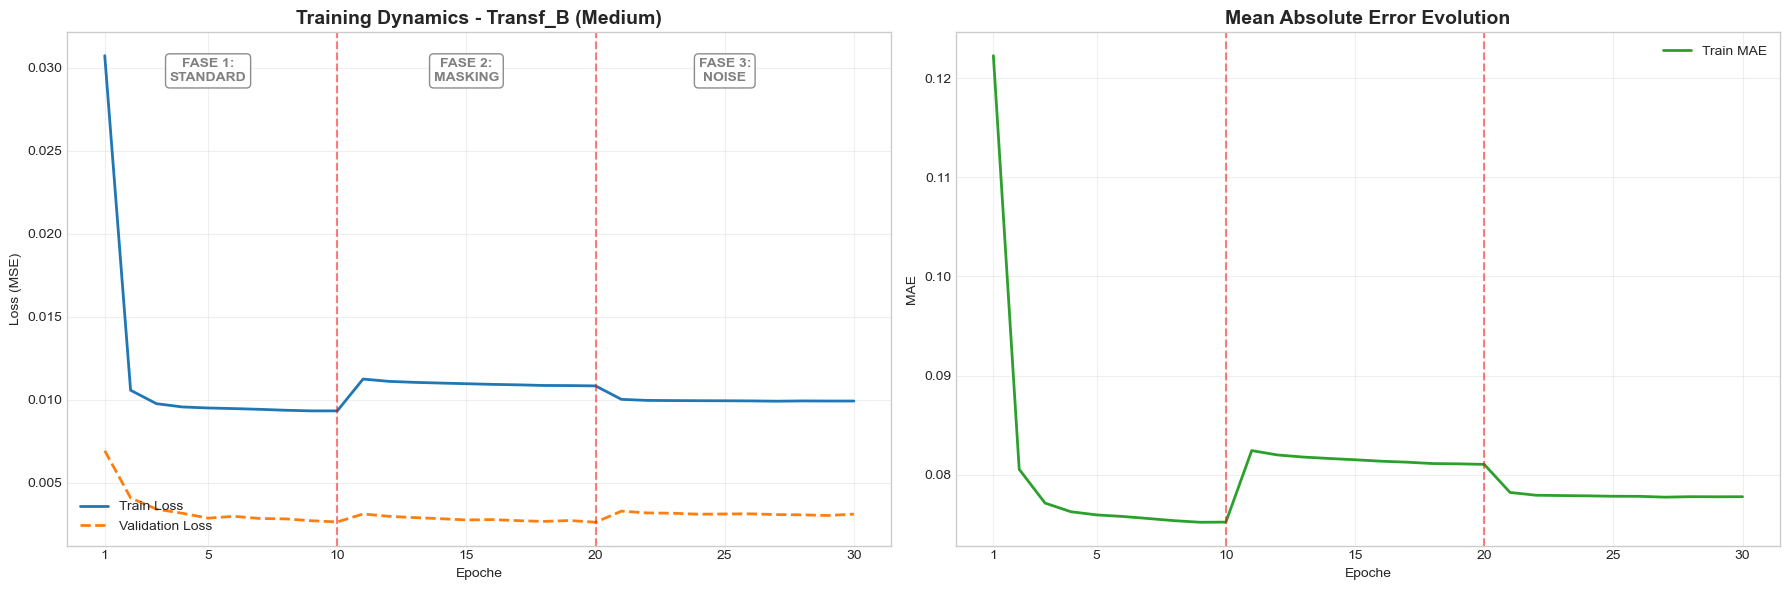

🔮 Generando grafici di predizione per: Transf_B (Medium)
Generazione predizioni per il grafico...


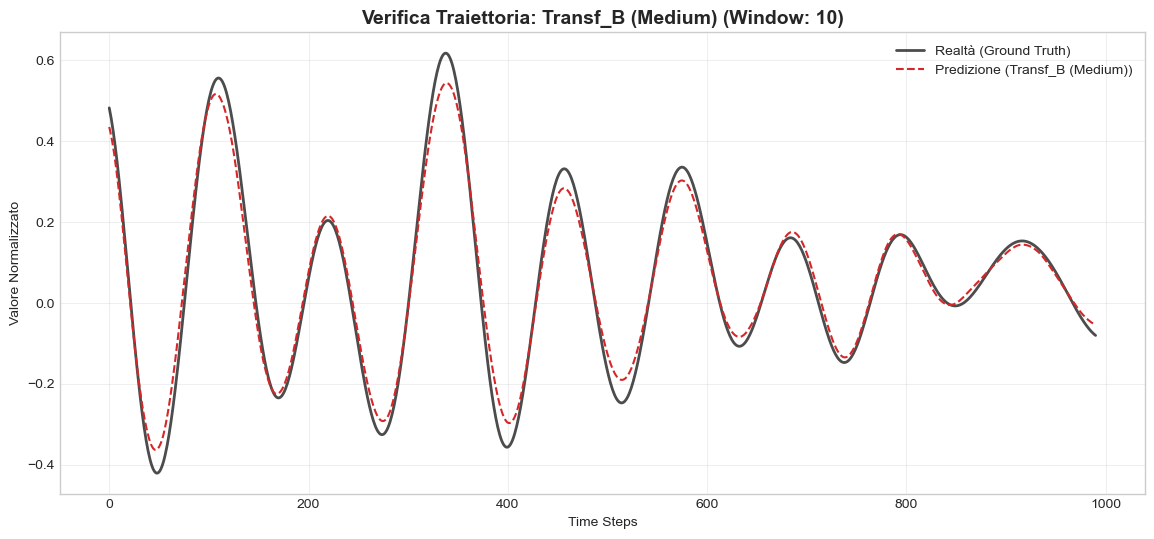


📊 Generando grafici di addestramento per: Transf_C (Large - Deep)


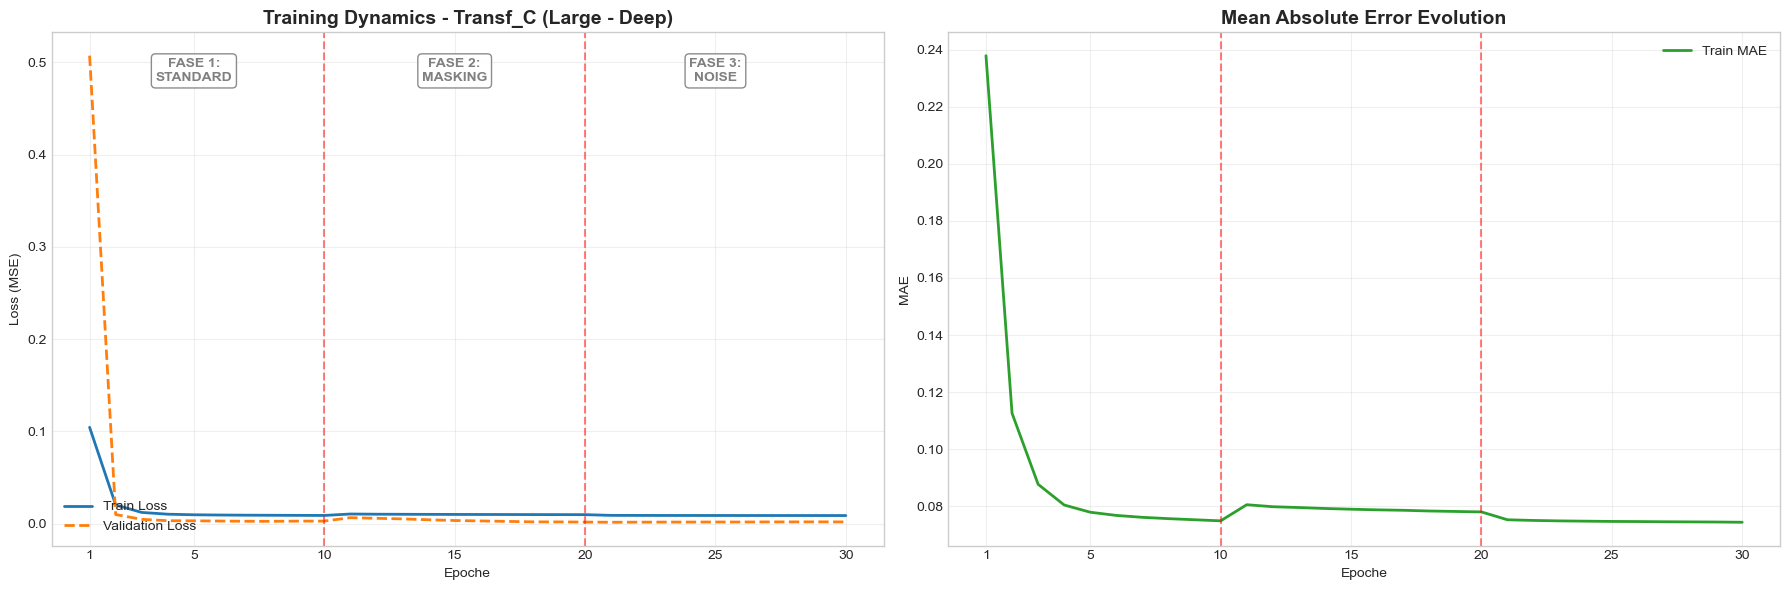

🔮 Generando grafici di predizione per: Transf_C (Large - Deep)
Generazione predizioni per il grafico...


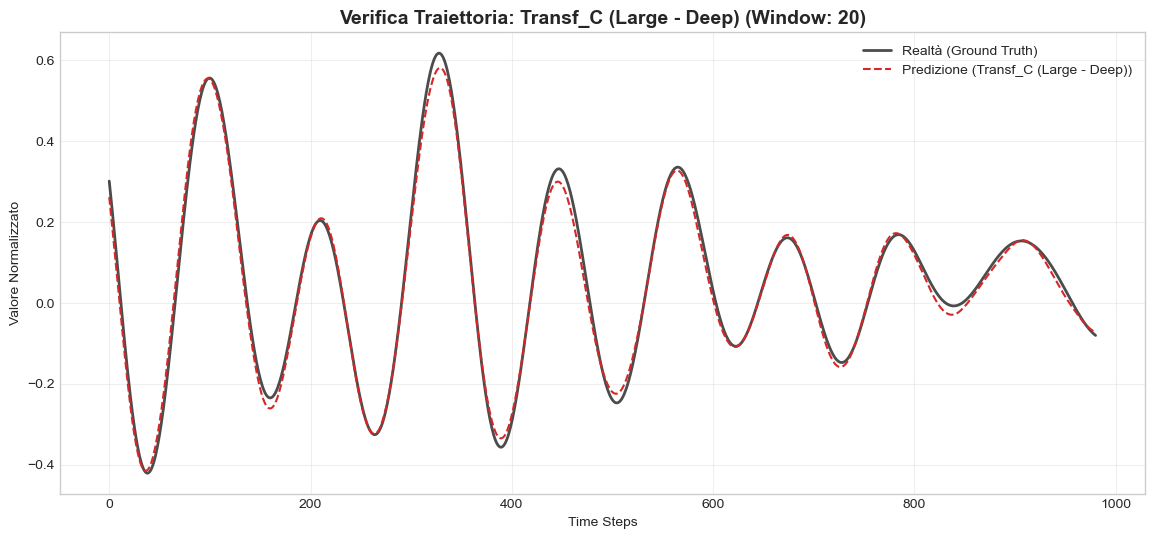

In [65]:
# --- CONFIGURAZIONE PERCORSI ---
MODEL_DIR = '../models'
PLOT_DIR = '../plots'
os.makedirs(PLOT_DIR, exist_ok=True)

def run_full_visualization_cycle():
    # Definiamo i gruppi di configurazioni da processare
    config_groups = {
        "rnn": HYPERPARAMETERS_LIST,
        "transf": TRANSFORMER_CONFIGS
    }

    for m_type, configs in config_groups.items():
        for conf in configs:
            name = conf['name']
            safe_name = name.replace(" ", "_").replace("(", "").replace(")", "")
            
            # 1. RECUPERO STORIA (CSV) E GRAFICI LOSS/MAE
            csv_path = f"{MODEL_DIR}/history/{m_type}_{safe_name}.csv"
            if os.path.exists(csv_path):
                print(f"\nGenerando grafici di addestramento per: {name}")
                history_df = pd.read_csv(csv_path)
                # Convertiamo il dataframe in dizionario per le tue funzioni
                history_dict = history_df.to_dict(orient='list')
                
                plot_filename = f"loss_{m_type}_{safe_name}.png"
                plot_training_phases_detailed(history_dict, name, plot_filename)
            else:
                print(f"Storia non trovata per {name} al percorso: {csv_path}")

            # 2. RICARICAMENTO MODELLO E GRAFICI PREDIZIONE
            weights_path = f"{MODEL_DIR}/weights/{m_type}_{safe_name}.weights.h5"
            if os.path.exists(weights_path):
                print(f"Generando grafici di predizione per: {name}")
                
                # Istanziamo l'architettura corretta
                if m_type == "rnn":
                    model = QuantumRNN(hidden_units=conf['units'], output_dim=55, dropout_rate=conf['dropout'])
                else:
                    model = QuantumTransformer(
                        num_layers=conf['num_layers'], embed_dim=conf['embed_dim'],
                        num_heads=conf['num_heads'], ff_dim=conf['ff_dim'],
                        output_dim=55, input_seq_len=conf['window_size'], dropout_rate=conf['dropout']
                    )
                
                # Dummy pass per inizializzare i pesi e caricamento
                dummy_input = tf.random.uniform((1, conf['window_size'], 55))
                _ = model(dummy_input)
                model.load_weights(weights_path)
                
                pred_filename = f"pred_{m_type}_{safe_name}.png"
                # Assicurati che test_traj_norm sia disponibile nel tuo ambiente
                plot_trajectory_check(model, test_traj_norm, conf['window_size'], name, pred_filename)
                
                # Pulizia memoria dopo ogni modello per evitare crash
                tf.keras.backend.clear_session()
            else:
                print(f"Pesi non trovati per {name} al percorso: {weights_path}")

# Avvia il ciclo
run_full_visualization_cycle()